3_0_model900.txt
900
0_0_model800.txt
1600
3_0_model100.txt
100
3_0_model800.txt
800
0_0_model500.txt
1000
4_6_model800.txt
1600
3_0_model500_increment_learning.txt
1000
3_0_model50.txt
50
3_0_model600.txt
1100
3_0_model1000_validation.txt
2000
4_6_model500.txt
1000
3_0_model500.txt
500
3_0_model700.txt
700
3_0_model200.txt
200
3_0_model1000.txt
1000


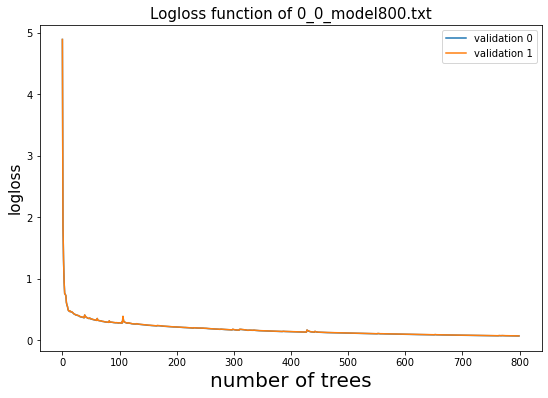

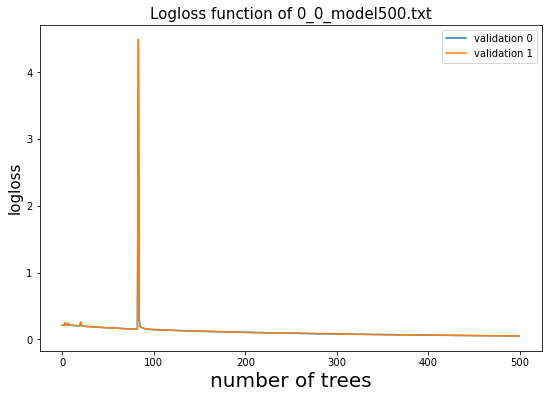

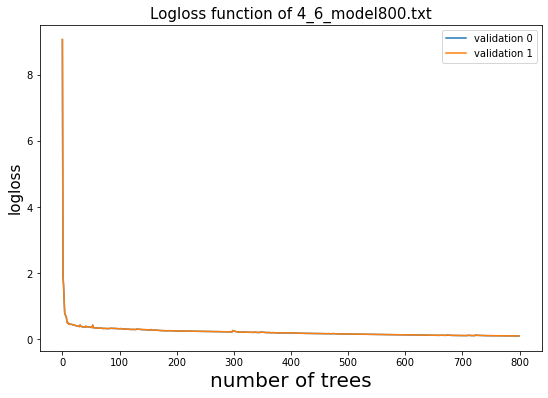

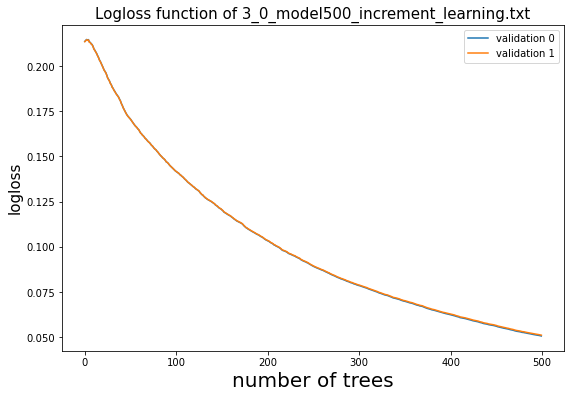

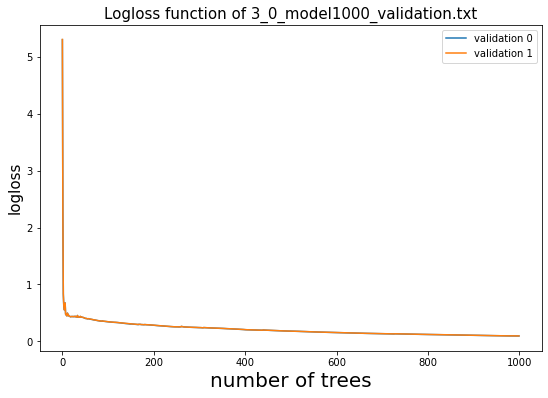

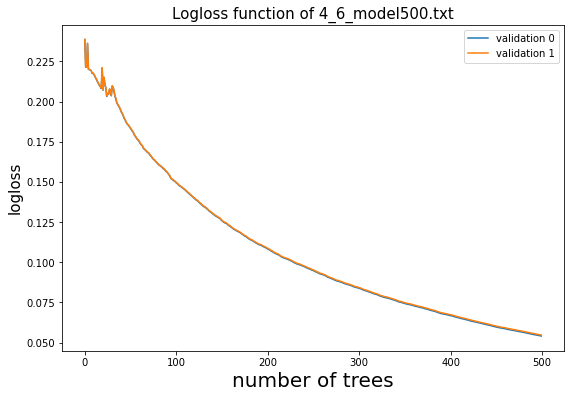

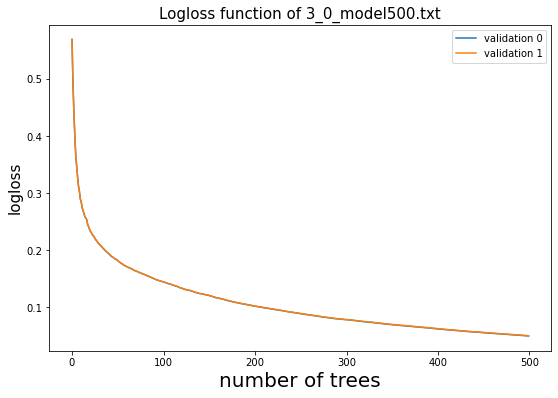

In [2]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import functions as fc
from xgboost import XGBClassifier




path = "/ceph/aavocone/models/"


train_loss = []
val_loss = []
for files in os.listdir(path):
    print(files)
    model = XGBClassifier()
    model.load_model(f"{path}{files}")
    print(model.best_ntree_limit)

    if len(model.evals_result().keys()) == 2:
        loss_0 = model.evals_result()["validation_0"]["logloss"]
        loss_1 = model.evals_result()["validation_1"]["logloss"]
        plt.figure(figsize=(9,6))
        x = range(len(loss_1))
        plt.plot(x,loss_0, label = "validation 0")
        plt.plot(x,loss_1, label = "validation 1")
        plt.xlabel("number of trees", fontsize = 20)
        plt.ylabel("logloss",fontsize=15)
        plt.title(f"Logloss function of {files}", fontsize = 15)
        plt.legend()
    else:
        pass